In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

tf.config.threading.set_intra_op_parallelism_threads(64)
tf.config.threading.set_inter_op_parallelism_threads(64)

# Load the data
X = pd.read_csv('texas_predict.csv')
y = pd.read_csv('texas_response.csv')

# Replace missing values in y with NaN
y = y.replace("?", np.nan)  # If missing values are marked with "?" in the dataset
y_numeric = y.select_dtypes(include="number")  # Remove 'statecounty'

# Normalize X (remove the 'statecounty' column)
X_numeric = X.select_dtypes(include='number')  # Remove 'statecounty'
X_numeric.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.2)

In [2]:
#y_train = y_train.fillna(y_train.mean())

In [3]:
X

,Healthcare_General_Practice_Provider_Rate_per100000_HRSA2020,Healthcare_Family_Medicine_Provider_Rate_per100000_HRSA2020,Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20,Population_With_Health_Insurance_ACS2016_20,Population_Without_Health_Insurance_ACS2016_20,Percent_Population_Without_Health_Insurance_ACS2016_20,Population_18yrs_And_Under_Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20,Population_18yrs_And_Under_With_Health_Insurance_ACS2016_20,Population_18yrs_And_Under_Without_Health_Insurance_ACS2016_20,PercentPopulation_18yrs_And_Under_Without_Health_Insurance_ACS2016_20,...,Percent_of_Farmers_Market_Accept_SNAP_USDA_2018,Number_of_Farmers_Market_Accept_WIC_USDA_2018,Percent_of_Farmers_Market_Accept_WIC_USDA_2018,Number_of_Farmers_Market_Accept_WIC_Cash_USDA_2018,Percent_of_Farmers_Market_Accept_SNAP_USDA_2018.1,Number_of_Farmers_Market_Accept_SFMNP_USDA_2018,Percent_of_Farmers_Market_Accept_SFMNP_USDA_2018,Number_of_Recreation_Fitness_Facilities_Per1000_Residents_USDA_2016,statecounty,state_number
0,1.842105,-0.335821,0.348177,0.298886,0.869736,0.968203,0.426194,0.371085,1.330659,1.289223,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,48Anderson County,48
1,0.000000,0.339552,-0.125055,-0.161183,0.289361,1.858506,-0.016325,-0.053994,0.738215,2.059148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,48Andrews County,48
2,0.631579,0.246269,1.080893,0.913108,2.803906,1.610493,1.280293,1.129851,3.542628,1.606015,...,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.833333,48Angelina County,48
3,0.000000,-0.417910,-0.022175,-0.060470,0.408205,1.475358,-0.062213,-0.084252,0.437312,1.547870,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,48Aransas County,48
4,0.000000,-1.044776,-0.294758,-0.300120,-0.193665,1.060413,-0.296488,-0.296907,-0.090939,1.531830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,48Archer County,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,4.526316,-0.399254,0.340530,0.280870,0.972046,1.170111,0.244799,0.195326,1.114009,1.527820,...,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.000000,48Wood County,48
250,6.052632,-0.615672,-0.296485,-0.319330,-0.010748,2.721781,-0.233494,-0.265259,0.493480,3.839599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,48Yoakum County,48
251,0.000000,1.873134,-0.133206,-0.164453,0.230249,1.683625,-0.113084,-0.145539,0.584420,2.418045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.166667,48Young County,48
252,0.000000,-1.044776,-0.195837,-0.238710,0.294528,2.774245,-0.078724,-0.093669,0.303577,1.257143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,48Zapata County,48


In [4]:
print(X_train.isnull().sum())
print(X_train.isin([np.inf, -np.inf]).sum())
print(y_train.isnull().sum())


Healthcare_General_Practice_Provider_Rate_per100000_HRSA2020                  0
Healthcare_Family_Medicine_Provider_Rate_per100000_HRSA2020                   0
Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20    0
Population_With_Health_Insurance_ACS2016_20                                   0
Population_Without_Health_Insurance_ACS2016_20                                0
                                                                             ..
Percent_of_Farmers_Market_Accept_SNAP_USDA_2018.1                             0
Number_of_Farmers_Market_Accept_SFMNP_USDA_2018                               0
Percent_of_Farmers_Market_Accept_SFMNP_USDA_2018                              0
Number_of_Recreation_Fitness_Facilities_Per1000_Residents_USDA_2016           0
state_number                                                                  0
Length: 228, dtype: int64
Healthcare_General_Practice_Provider_Rate_per100000_HRSA2020                  0
Healthcare_Fam

In [5]:
def masked_loss(y_true, y_pred):
    mask = tf.math.is_finite(y_true)  # Create a mask to ignore NaNs
    diff = tf.boolean_mask(y_true - y_pred, mask)  # Ignore NaNs
    return tf.reduce_mean(tf.square(diff))

def build_model(hp):
    model = tf.keras.models.Sequential()
    input_dim = X_train.shape[1]  # Ensure correct input dimension
    model.add(tf.keras.layers.InputLayer(input_shape=(input_dim,)))

    # Tune number of layers and units
    for i in range(hp.Int('num_layers', 2, 3)):  # Between 2 and 3 layers
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                     min_value=128,
                                                     max_value=256,  # Adjust range
                                                     step=64),
                                        activation='relu'))
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_' + str(i),
                                                   min_value=0.2,
                                                   max_value=0.4,
                                                   step=0.1)))

    # Output layer matching y_train shape
    output_dim = y_train.shape[1] if len(y_train.shape) > 1 else 1
    model.add(tf.keras.layers.Dense(output_dim, activation='linear'))

    # Compile model with masked loss
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
                  loss=masked_loss,
                  metrics=['mae'])
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='multi_target_hyperparam_tuning',
    max_consecutive_failed_trials=10
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [6]:
# tuner.results_summary()


In [7]:

# shap graph starts
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=64, verbose = 1)

best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Loss: {loss}, Test MAE: {mae}")

best_model.save('best_multi_target_model.h5')

Trial 20 Complete [00h 00m 12s]
val_mae: 40.04135704040527

Best val_mae So Far: 28.94703769683838
Total elapsed time: 00h 03m 23s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3152.2937 - mae: 44.6965 


Best Model Test Loss: 3082.617431640625, Test MAE: 44.37193298339844


In [8]:
from tensorflow.keras.models import load_model
import shap
import matplotlib.pyplot as plt

# Load the saved model
best_model = load_model('best_multi_target_model.h5', compile=False)
assert list(X_train.columns) == list(X_test.columns), "Mismatch in feature columns"


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Swapping PermutationExplainer for GradientExplainer
X_train_np = X_train.values  # Convert X_train to NumPy array
X_test_np = X_test.values    # Convert X_test to NumPy array

# Initialize GradientExplainer
explainer = shap.GradientExplainer(best_model, X_train_np)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_np)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(51, 228))']
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 228))']
  warnings.warn(msg)


In [10]:
print(type(shap_values))
print(np.array(shap_values).shape)


<class 'numpy.ndarray'>
(51, 228, 1)


In [11]:
shap_values = np.squeeze(shap_values)  

import pandas as pd

feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

print("Feature importance:")
print(feature_importance)

Feature importance:
                                               feature  importance
212  Amount_of_SNAP_Redemption_Per_SNAP_Authorized_...    8.441572
178  Percent_Housing_with_1_or_Less_Occupant_Per_Ro...    6.967020
213       Amount_of_SNAP_Benefits_Per_Capita_USDA_2017    6.955566
163  Percentage_Fee_for_Service_FFS_Medicare_Enroll...    6.786221
164  Presence_Of_Health_Relate_Drinking_Water_Viola...    6.673330
..                                                 ...         ...
222  Number_of_Farmers_Market_Accept_WIC_Cash_USDA_...    0.280875
203  AA_Black_Population_With_Low_Access_To_Store_U...    0.231259
216                Number_of_FDPIR_Available_USDA_2015    0.134308
224    Number_of_Farmers_Market_Accept_SFMNP_USDA_2018    0.129344
227                                       state_number    0.000000

[228 rows x 2 columns]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


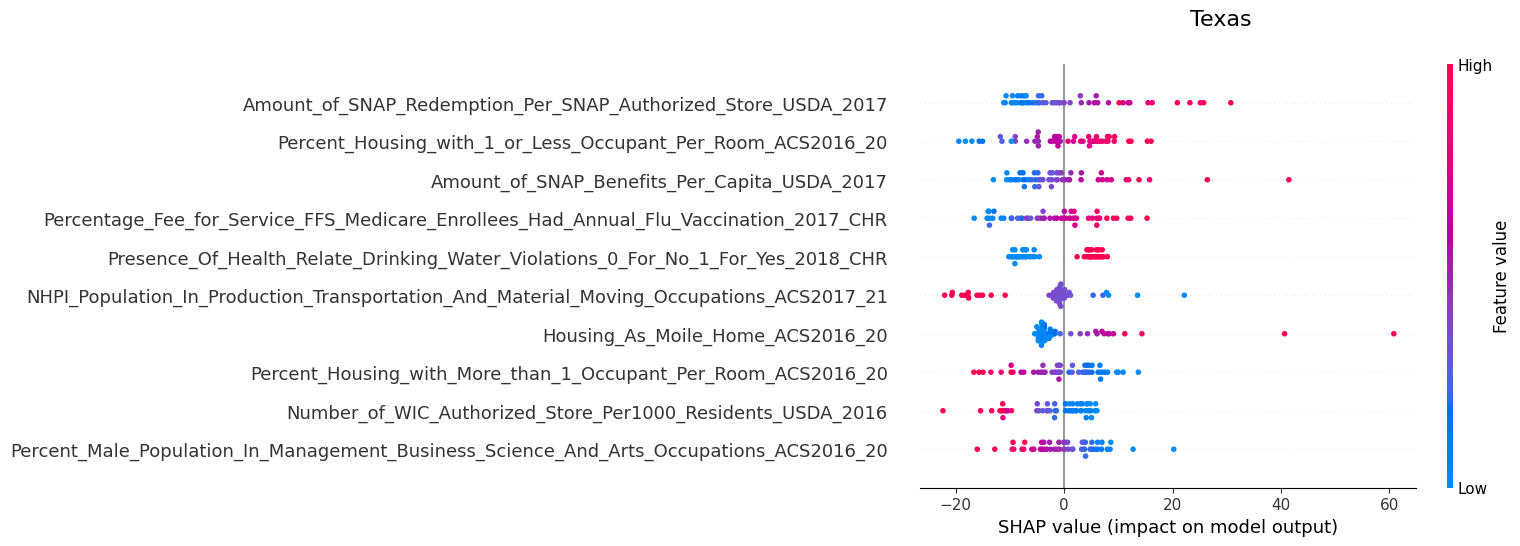

In [15]:
import shap
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X_test, max_display=10, show=False)
plt.gcf().suptitle("Texas", fontsize=16)
plt.show()

